In [1]:
import datetime
import os
import time
import pickle
import wandb
import math
import cv2

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.compat.v1 as tfc
import numpy as np

from PIL import Image,ImageOps
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard
from keras import callbacks
from sklearn.decomposition import PCA
from wandb.keras import WandbCallback
from statistics import mean

#import model generators
import stefan_cnn_v1
import oliver_cnn_v1
import sequential_nn
import new_cnn_oliver

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_options= tfc.GPUOptions(per_process_gpu_memory_fraction = 0.8)

try: sess.close() 
except: pass
sess = tfc.InteractiveSession(config=tfc.ConfigProto(gpu_options=gpu_options))
tf.executing_eagerly()

Num GPUs Available:  1
Found GPU at: /device:GPU:0


True

## CONSTANTS

In [3]:
CHANNELS = 1 #1 for grayscale, 3 for RGB
IMG_SIZE = 64
#INPUT_SHAPE = [IMG_SIZE,int(IMG_SIZE/2),CHANNELS]
INPUT_SHAPE = [IMG_SIZE,IMG_SIZE,CHANNELS]

BATCH_SIZE = 256
EPOCHS = 300

ROT= 20


NAME = f"O_CNN{int(time.time())}"
SOURCE = "train_images/"
RES = f"train_images_res_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}/"

### TensorBoard + Callbacks

In [4]:
#wandb.tensorboard.patch(root_logdir="logs/")

In [5]:
#%load_ext tensorboard
#%tensorboard --logdir logs

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 15, 
                                        restore_best_weights = True)

## Adjust CSV

In [6]:
#adjust names to fit
train_csv = "train.csv"
train_df = pd.read_csv(train_csv)
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

species_labels = list(train_df.species.unique())
images = train_df['image']
sid = train_df['individual_id']
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


amount of species: 26


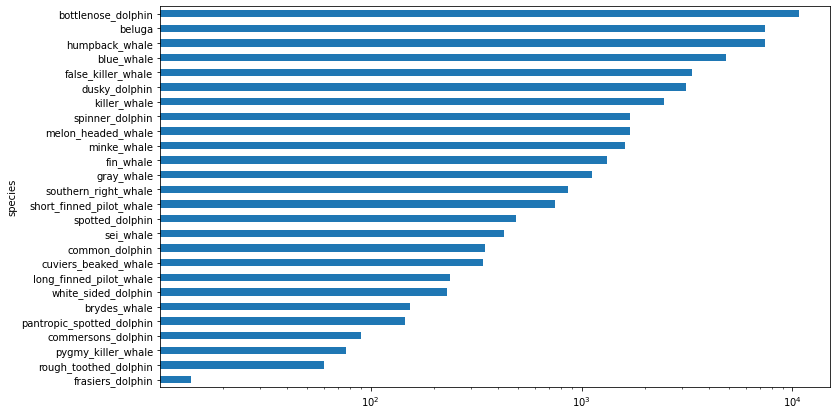

In [7]:
print(f"amount of species: {len(train_df.species.unique())}")
plt.figure(figsize=(12, 7))
train_df.groupby(by='species').size().sort_values().plot.barh().set_xscale('log')

In [8]:
thresh = 1000
max_instances = 3000

#train_df.species = train_df.species.apply(lambda x: 'other_dolphin' if ('dolphin' in x and not "bottlenose" in x) else x)
species_counts = train_df['species'].value_counts()



final_species = species_counts[species_counts > thresh].index.tolist()
undersample_species = species_counts[species_counts > max_instances].index.tolist()
mask = train_df.species.apply(lambda x: any(item for item in final_species if item in x))
final_df = train_df[mask]

In [9]:
def undersample(df, index, max_instances):
    sampled = df[df.species == index].sample(n=max_instances, random_state=101) if len(df[df.species == index]) > max_instances else df[df.species == index]
    return  sampled

dfs = []
for species in final_species:
    dfs.append(undersample(final_df,species,max_instances))

final_train_df = pd.concat(dfs,axis=0)
final_train_df["species"].value_counts()

train_df=final_train_df

In [10]:
def get_id(sp):
    return species_labels.index(sp)
##encode species
#train_df["species"] = train_df.apply(lambda row :get_id(row["species"]),axis = 1)
#labels = train_df["species"]

##one-hot encode species
labels = pd.get_dummies(train_df.species, prefix='species_')
labels

,species__beluga,species__blue_whale,species__bottlenose_dolphin,species__dusky_dolphin,species__false_killer_whale,species__fin_whale,species__gray_whale,species__humpback_whale,species__killer_whale,species__melon_headed_whale,species__minke_whale,species__spinner_dolphin
43925,0,0,1,0,0,0,0,0,0,0,0,0
42060,0,0,1,0,0,0,0,0,0,0,0,0
19821,0,0,1,0,0,0,0,0,0,0,0,0
17429,0,0,1,0,0,0,0,0,0,0,0,0
50351,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
50778,0,0,0,0,0,0,1,0,0,0,0,0
50842,0,0,0,0,0,0,1,0,0,0,0,0
50887,0,0,0,0,0,0,1,0,0,0,0,0
50935,0,0,0,0,0,0,1,0,0,0,0,0


In [11]:
AMT_CLASSES = labels.shape[1]

## Resize Images
This helps the model fitting --> picture preprocessing gets less intensive

In [12]:
if not os.path.exists(RES):
    os.mkdir(RES)
    for image in tqdm(images):
        savePath = RES + image  
        if not os.path.exists(savePath):
            imgPath = SOURCE + image
            im = Image.open(imgPath)
            im.thumbnail((IMG_SIZE,IMG_SIZE), Image.ANTIALIAS)
            im = ImageOps.pad(im, (IMG_SIZE,IMG_SIZE), color='black')

            #resizedImage = im.resize((IMG_SIZE, IMG_SIZE), PIL.Image.ANTIALIAS)
            #resizedImage.save(savePath) 
            im.save(savePath)

In [13]:
#full_img = list(map(RES.__add__, images))
full_img = list(map(RES.__add__,train_df['image']))

## PCA

In [51]:
img_array = []
for img in tqdm(full_img):
    im = np.array(Image.open(img).convert('L'))/255
    img_array.append(pd.Series(im.flatten(),name=img))
#img_array

100%|███████████████████████████████████████████████████████████████████████████| 51033/51033 [03:49<00:00, 222.80it/s]


#### PCA Curve

In [52]:
test_pca = PCA(300)
test_pca_analyzed = test_pca.fit(img_array)

Text(0, 0.5, 'cum variance')

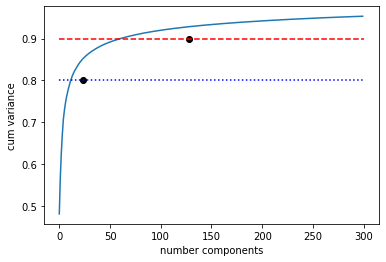

In [53]:
plt.plot(np.cumsum(test_pca_analyzed.explained_variance_ratio_))
plt.hlines(0.9,color="red",xmin=0, xmax=300, linestyle="dashed")
plt.hlines(0.8,color="blue",xmin=0, xmax=300, linestyle="dotted")
#plt.scatter(128,0.9, color='black')
#plt.scatter(23,0.8, color='black' )
plt.xlabel("number components")
plt.ylabel("cum variance")

#### final fit with desired specificity

In [ ]:
pca = PCA(n_components=0.9)
pca_analyzed = pca.fit(img_array)

In [ ]:
fig, axes = plt.subplots(21,6,figsize=(10,50),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca_analyzed.components_[i].reshape(INPUT_SHAPE),cmap="gray")

In [ ]:
PCA_COMPONENTS = pca_analyzed.components_.shape[0]
print(f"Amount of PCA components: {PCA_COMPONENTS}")

#### Show first 3 PC

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
show_pca = PCA(3)
show_pca_analyzed = show_pca.fit(img_array)

X_pca = show_pca.transform(img_array) 

In [ ]:
Xax = X_pca[:,0]
Yax = X_pca[:,1]
Zax = X_pca[:,2]

In [ ]:
%matplotlib notebook
import matplotlib.colors as pltc
from random import sample
all_colors = [k for k,v in pltc.cnames.items()]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')

lbls = train_df.species.unique()
for i,l in enumerate(lbls):
    colors = sample(all_colors, len(lbls))
    ix=np.where(train_df.species==l)
    ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=colors[i], s=40,label=lbls[i])
# for loop ends
ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
ax.set_zlabel("Third Principal Component", fontsize=14)

ax.legend(bbox_to_anchor=(1.15, 1.0),loc="upper left")
for angle in range(0, 360):
    ax.view_init(30, angle)
plt.show()

## Input Pipeline

In [14]:
@tf.function
def process_tuple(image,label):
    img = tf.io.read_file(image)
    img = tf.image.decode_jpeg(img, channels=CHANNELS)
    

    
    img = tf.image.random_flip_left_right(img)
    
    lower,upper,size,max_delta = 0.1,0.3,0,0
    img = tf.image.random_contrast(img, lower, upper, seed=None)
    #img = tf.image.random_crop(img, size, seed=None, name=None)
    img = tf.image.random_brightness(img, max_delta, seed=None)
    
    #img = tf.keras.preprocessing.image.random_rotation(
        #img, ROT, row_axis=0, col_axis=1, channel_axis=2)
    
    img = tf.image.convert_image_dtype(img, tf.float16) / 255
    return img, label

def pca_transform(image,label):
    toast = image.numpy()[:, :, 0].flatten()[:,np.newaxis]
    toast = np.reshape(toast, (1,-1)) 
    pca_data = pca.transform(toast).flatten()
    return pca_data, label

@tf.function
def _adjust_shapes(pca_data, label): 
    pca_data.set_shape(tf.TensorShape([PCA_COMPONENTS]))
    label.set_shape(tf.TensorShape([AMT_CLASSES]))
    return pca_data, label

In [15]:
dataset = tf.data.Dataset.from_tensor_slices((full_img, labels)).shuffle(1000).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
#dataset = dataset.map(lambda x,y: tf.py_function(func=pca_transform,inp=[x,y],Tout=[tf.float16,tf.uint8]),num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
#dataset = dataset.map(_adjust_shapes,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

In [16]:
TRAIN_SPLIT = 0.7
VAL_TEST_SPLIT = (1-TRAIN_SPLIT)/2

image_count = dataset.cardinality().numpy()
train_size = int(image_count*TRAIN_SPLIT)
val_test_size = int(image_count*VAL_TEST_SPLIT)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_test_size)
test_ds = dataset.skip(train_size).skip(val_test_size)


train_batched = train_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_batched = val_ds.batch(batch_size=int(BATCH_SIZE*0.15)).cache().prefetch(tf.data.AUTOTUNE)
test_batched = test_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

### Benchmark Dataset

In [17]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in tqdm(dataset):
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

In [18]:
benchmark_ds = dataset.take(1)
#for d in benchmark_ds:
#    print(d)
benchmark(benchmark_ds)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]

Execution time: 0.5627478999999767


## Modelling

In [19]:
import pprint
import math

from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adagrad, SGD, Adam, Nadam, Adadelta
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback, EarlyStopping

#### WandB

In [20]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'accuracy',
    'goal': 'maximize'   
    }
sweep_config['metric'] = metric

parameters_dict = {
    'epochs': {
        'value': 5
        },
    'batch_size': {
        'values': [32,64,128,256]
        },
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
        },
    'activation': {
        'values': ['relu', 'tanh','sigmoid']
        },
    'optimizer': {
        'values': ['adam', 'sgd','adadelta','adagrad','nadam']
        },
    'hidden_layer_size': {
        'values': [32,64, 128, 256]
        },
    'dropout': {
          'values': [0.1,0.2, 0.3, 0.4,0.5]
        }
    }

sweep_config['parameters'] = parameters_dict



sweep_id = wandb.sweep(sweep_config, project="my-test-project",entity="dolphin_project")

Create sweep with ID: hjw6rty0
Sweep URL: https://wandb.ai/dolphin_project/my-test-project/sweeps/hjw6rty0


In [21]:
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'accuracy'},
 'parameters': {'activation': {'values': ['relu', 'tanh', 'sigmoid']},
                'batch_size': {'values': [32, 64, 128, 256]},
                'dropout': {'values': [0.1, 0.2, 0.3, 0.4, 0.5]},
                'epochs': {'value': 5},
                'hidden_layer_size': {'values': [32, 64, 128, 256]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['adam',
                                         'sgd',
                                         'adadelta',
                                         'adagrad',
                                         'nadam']}}}


#### Model Keras

In [22]:
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 5,
        'batch_size': 128,
        'learning_rate': 1e-3,
        'activation': 'relu',
        'optimizer': 'nadam',
        'hidden_layer_size': 128,
        'dropout': 0.5,
    }
    wandb.init(config=config_defaults)
    config = wandb.config
    
    

    model = Sequential() 
    model.add(keras.Input(shape=INPUT_SHAPE))#Input - dont change
    
    
    #block1
    model.add(Conv2D(filters=64, kernel_size=5, activation=config.activation, padding='same', input_shape=[64, 64, 1]))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D())
              
    #block2
    model.add(Conv2D(filters=128, kernel_size=3, activation=config.activation, padding='same'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D())
    
    #block3
    model.add(Conv2D(filters=256, kernel_size=3, activation=config.activation, padding='same'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D())
    
    #block4
    model.add(Conv2D(filters=512, kernel_size=3, activation=config.activation, padding='same'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D())
    

    model.add(Flatten())          
    model.add(Dense(units=256, activation=config.activation))

    #Output - dont change
    model.add(Dense(AMT_CLASSES, activation = "softmax"))

    
    
    if config.optimizer=='sgd':
        optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=0.9, nesterov=True)
    elif config.optimizer=='adagrad':
        optimizer = Adagrad(learning_rate=config.learning_rate)
    elif config.optimizer=='adam':
        optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=="adadelta":
        optimizer = Adadelta(learning_rate=config.learning_rate)
    elif config.optimizer=='nadam':
        optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

        
    model.compile(loss = "categorical_crossentropy", optimizer = config.optimizer, metrics=['categorical_accuracy'])
    model.fit(train_batched, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=val_batched,
              callbacks=[WandbCallback(),
                          EarlyStopping(patience=10, restore_best_weights=True)])


In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: bzkt39zj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.003481647847448699
wandb: 	optimizer: adadelta
wandb: Currently logged in as: dolphin_project (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/5
77/77 [==============================] - 246s 3s/step - loss: 2.4841 - accuracy: 0.1972 - val_loss: 2.4863 - val_accuracy: 0.0014
Epoch 2/5
77/77 [==============================] - 20s 260ms/step - loss: 2.4825 - accuracy: 0.1485 - val_loss: 2.4874 - val_accuracy: 0.0014
Epoch 3/5
77/77 [==============================] - 20s 260ms/step - loss: 2.4810 - accuracy: 0.1429 - val_loss: 2.4885 - val_accuracy: 0.0014
Epoch 4/5
77/77 [==============================] - 20s 263ms/step - loss: 2.4794 - accuracy: 0.1402 - val_loss: 2.4897 - val_accuracy: 0.0014
Epoch 5/5
77/77 [==============================] - 20s 261ms/step - loss: 2.4777 - accuracy: 0.1402 - val_loss: 2.4909 - val_accuracy: 0.0014


accuracy,█▂▁▁▁
epoch,▁▃▅▆█
loss,█▆▅▃▁
val_accuracy,▁▁▁▁▁
val_loss,▁▃▄▆█
accuracy,0.1402
best_epoch,0
best_val_loss,2.48626
epoch,4
loss,2.4777
val_accuracy,0.00143


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o24ucabo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.06287745080766116
wandb: 	optimizer: adagrad
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/5
77/77 [==============================] - 21s 264ms/step - loss: 1.2097 - accuracy: 0.6535 - val_loss: 3.8940 - val_accuracy: 0.2012
Epoch 2/5
77/77 [==============================] - 20s 259ms/step - loss: 1.3382 - accuracy: 0.5986 - val_loss: 4.1599 - val_accuracy: 0.2012
Epoch 3/5
77/77 [==============================] - 20s 260ms/step - loss: 1.4197 - accuracy: 0.5333 - val_loss: 4.3216 - val_accuracy: 0.2012
Epoch 4/5
77/77 [==============================] - 20s 260ms/step - loss: 1.4995 - accuracy: 0.4918 - val_loss: 4.4481 - val_accuracy: 0.2012
Epoch 5/5
77/77 [==============================] - 20s 259ms/step - loss: 1.5773 - accuracy: 0.4454 - val_loss: 4.5607 - val_accuracy: 0.2012


accuracy,█▆▄▃▁
epoch,▁▃▅▆█
loss,▁▃▅▇█
val_accuracy,▁▁▁▁▁
val_loss,▁▄▅▇█
accuracy,0.44544
best_epoch,0
best_val_loss,3.89403
epoch,4
loss,1.5773
val_accuracy,0.20124


wandb: Agent Starting Run: m9jj4us4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.07936154626936698
wandb: 	optimizer: adagrad
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/5
77/77 [==============================] - 21s 264ms/step - loss: 2.4479 - accuracy: 0.2434 - val_loss: 2.5148 - val_accuracy: 0.0000e+00
Epoch 2/5
77/77 [==============================] - 20s 262ms/step - loss: 2.3455 - accuracy: 0.2138 - val_loss: 2.5894 - val_accuracy: 0.0160
Epoch 3/5
51/77 [==================>...........] - ETA: 6s - loss: 2.1579 - accuracy: 0.2335

In [44]:
cval = current_model.evaluate(test_batched, verbose = 0)


wandb.log({"test loss" : cval[0]})
wandb.log({"test acc" : cval[1]})
wandb.log({"test error rate" : round((1-cval[1])*100,2)})
run.finish()

NameError: name 'current_model' is not defined

In [25]:
print("test loss, test acc:", cval)

test loss, test acc: [1.452424168586731, 0.5572100281715393]


In [ ]:
with open(f'seqnn.pkl', 'wb') as file:
    pickle.dump(current_model,file)